# Train Vehicles Agents


- crée un network à partir d'un fichier .osm et des trajectoires de véhiculess
- ajoute un flux de voiture sur les routes
- personnalise un Environnement pour le RL
- integre l'environnement pour RLlib et execute la simulation


In [1]:
from flow.core.params import VehicleParams
from flow.core.params import NetParams, SumoCarFollowingParams
from flow.core.params import InitialConfig
from flow.core.params import EnvParams
from flow.core.params import SumoParams
from flow.controllers import RLController, IDMController
from flow.networks import Network
from flow.core.params import InFlows

## Crée le network

Specifie les noms des routes du network dont les vehicules peuvent être s'insérer

In [2]:
EDGES_DISTRIBUTION = ["-100822066","4794817","4783299#0","155558218"]

créer la classe Network pour spécifier les itinéraires possibles

In [3]:
class IssyOSMNetwork(Network):

    def specify_routes(self, net_params):
        return {
            "-100822066": [ #N
                "-100822066",
                "-352962858#1",
                "-352962858#0",
                "-4786940#1",
                 "-4786940#0",
            ],
            
            "4794817" : [ #Loop
                "4794817",
                "4786972#0",
                "4786972#1",
                "4786972#2",
                "4786965#1",
                "4786965#2",
                "4786965#3",
                "4795729",
                "-352962858#1",
                "4795742#0",
                "4795742#1",
                "4786965#3",
                "4786965#4",
                "4786965#5",
            ],
            
            "4783299#0": [    #E
                "4783299#0",
                "4783299#1",
                "4783299#2",
                "4783299#3",
                "4783299#4",
                "4783299#5",
                "4783299#6",
                "4786940#0",
                "4786940#1",
                "352962858#0",
                "352962858#1",
                "100822066",
            ],
            
            "155558218": [
                "155558218",
                "4786940#1",
                "352962858#0",
                "352962858#1",
                "100822066",
            ],     
        }

## Ajoute les flux de voiture

`IDMController` : The Intelligent Driver Model is a car-following model specifying vehicle dynamics by a differential equation for acceleration $\dot{v}$.

`RLController` : a trainable autuonomous vehicle whose actions are dictated by an RL agent. 

In [4]:
vehicles = VehicleParams()
vehicles.add("human",acceleration_controller=(IDMController, {}),num_vehicles=8)
vehicles.add("rl",acceleration_controller=(RLController, {}),num_vehicles=5,color="cyan")

- `vehs_per_hour`: nombre de vehicule par heure, uniformément espacés. Par exemple, comme il y a $60 \times 60 = 3600$ secondes dans une heure, le parametre $\frac{3600}{5}=720$ va faire rentrer des vehicules dans le network toutes les $5$ secondes.

- `probability`: c'est la probabilité qu'un véhicule entre dans le network toutes les secondes. Par exemple, si on la fixe à $0.2$, alors chaque seconde de la simulation un véhicule aura $\frac{1}{5}$ chance d'entrer dans le network

- `period`: C'est le temps en secondes entre 2 véhicules qui sont insérés. Par exemple, le fixer à $5$ ferait rentrer des véhicules dans le network toutes les $5$ secondes (ce qui équivaut à mettre `vehs_per_hour` à $720$).

<font color='red'>
$\rightarrow$ Exactement 1 seul de ces 3 paramètres doit être configurer !
</font>

In [5]:
#inflow = InFlows()
 
#for edge in EDGES_DISTRIBUTION:
#    inflow.add(veh_type = "human", edge = edge, probability = 0.1, depart_speed = 7)

## Lance une simulation avec Training RLlib

Pour qu'un environnement puisse être entrainé, l'environnement doit être accessible via l'importation à partir de flow.envs. 


<font color='red'>
Copier l'environnement créé dans un fichier .py et on importe l'environnement dans `flow.envs.__init__.py`.
Mettre le chemin absolu du fichier .osm .
</font> 

In [6]:
import json, ray
from ray.rllib.agents.registry import get_agent_class
from ray.tune import run_experiments
from ray.tune.registry import register_env

from flow.networks.ring import ADDITIONAL_NET_PARAMS
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from flow.core.params import VehicleParams, SumoCarFollowingParams

#from flow.envs import AccelEnv as myEnv
#ADDITIONAL_ENV_PARAMS = {"target_velocity": 20,"sort_vehicles": False,"max_accel": 1,"max_decel": 1}
from myenv import myEnv
ADDITIONAL_ENV_PARAMS = {"max_accel": 2, "max_decel": 2}

In [7]:
HORIZON = 200

In [8]:
# number of rollouts per training iteration
N_ROLLOUTS = 10
# number of parallel workers
N_CPUS = 2

# SUMO PARAM
sumo_params = SumoParams(sim_step=0.1, render=False, restart_instance=True, emission_path='data')

# ENVIRONMENT PARAM
env_params = EnvParams(additional_params=ADDITIONAL_ENV_PARAMS, horizon=HORIZON)

# NETWORK PARAM
path_file  = '/home/julien/projet_CIL4SYS/NOTEBOOKS/issy.osm'
net_params = NetParams( osm_path=path_file) # inflows=inflow,

# NETWORK
network = IssyOSMNetwork

# INITIAL CONFIG
initial_config = InitialConfig(edges_distribution=EDGES_DISTRIBUTION)


flow_params = dict( exp_tag   = "ISSY_RL_train", 
                    env_name  = myEnv,  
                    network   = IssyOSMNetwork,
                    simulator = 'traci', # simulator that is used by the experiment
                    sim       = sumo_params,
                    env       = env_params,
                    net       = net_params,
                    veh       = vehicles,
                    initial   = initial_config)

def setup_exps():
    """Return the relevant components of an RLlib experiment.

    Returns
    -------
    str
        name of the training algorithm
    str
        name of the gym environment to be trained
    dict
        training configuration parameters
    """
    alg_run   = "PPO"
    agent_cls = get_agent_class(alg_run)
    config    = agent_cls._default_config.copy()
    config["num_workers"]      = N_CPUS
    config["train_batch_size"] = HORIZON * N_ROLLOUTS
    config["gamma"]            = 0.999  # discount rate
    config["use_gae"]          = True
    config["lambda"]           = 0.97
    config["kl_target"]        = 0.02
    config["num_sgd_iter"]     = 10
    config['clip_actions']     = False  # FIXME(ev) temporary ray bug
    config["horizon"]          = HORIZON
    config["model"].update({"fcnet_hiddens": [3, 3]})
    
    # save the flow params for replay
    flow_json = json.dumps( flow_params, cls=FlowParamsEncoder, sort_keys=True, indent=4)
    config['env_config']['flow_params'] = flow_json
    config['env_config']['run'] = alg_run

    create_env, gym_name = make_create_env(params=flow_params, version=0)

    # Register as rllib env
    register_env(gym_name, create_env)
    
    return alg_run, gym_name, config


alg_run, gym_name, config = setup_exps()

ray.init(num_cpus=N_CPUS + 1)#, local_mode=True)

exp_tag = {"run": alg_run,
           "env": gym_name,
           "config": {**config},
           "checkpoint_freq": 500,
           "checkpoint_at_end": True,
           "max_failures": 999,
           "stop": {"training_iteration": 5}}

trials = run_experiments({flow_params["exp_tag"]: exp_tag}, verbose=0)

2020-04-07 19:01:48,696	INFO node.py:498 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2020-04-07_19-01-48_692202_2974/logs.
2020-04-07 19:01:48,819	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:34327 to respond...
2020-04-07 19:01:48,993	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:53897 to respond...
2020-04-07 19:01:49,009	INFO services.py:809 -- Starting Redis shard with 2.09 GB max memory.
2020-04-07 19:01:49,078	INFO node.py:512 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2020-04-07_19-01-48_692202_2974/logs.
2020-04-07 19:01:49,084	INFO services.py:1475 -- Starting the Plasma object store with 3.14 GB memory using /dev/shm.


TypeError: run_experiments() got an unexpected keyword argument 'convert_to_csv'

# Visualize

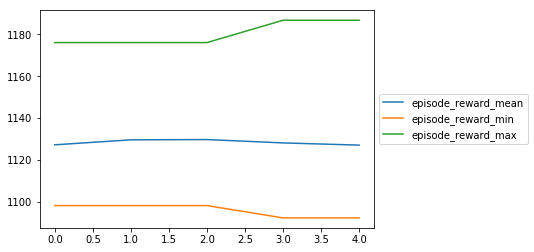

In [11]:
%run plot_ray_results.py ~/ray_results/ISSY_RL_train/PPO_myEnv-v0_0_2020-04-07_18-25-54325gofpt/progress.csv episode_reward_mean episode_reward_min episode_reward_max